# Sprint 深層学習スクラッチ 畳み込みニューラルネットワーク1

## 1.このSprintについて

### Sprintの目的
スクラッチを通してCNNの基礎を理解する

### どのように学ぶか
スクラッチで1次元用畳み込みニューラルネットワークを実装した後、学習と検証を行なっていきます。

## 2.1次元の畳み込みニューラルネットワークスクラッチ

畳み込みニューラルネットワーク（CNN） のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


このSprintでは1次元の 畳み込み層 を作成し、畳み込みの基礎を理解することを目指します。次のSprintでは2次元畳み込み層とプーリング層を作成することで、一般的に画像に対して利用されるCNNを完成させます。


クラスの名前はScratch1dCNNClassifierとしてください。クラスの構造などは前のSprintで作成したScratchDeepNeuralNetrowkClassifierを参考にしてください。

### 1次元畳み込み層とは
CNNでは画像に対しての2次元畳み込み層が定番ですが、ここでは理解しやすくするためにまずは1次元畳み込み層を実装します。1次元畳み込みは実用上は自然言語や波形データなどの 系列データ で使われることが多いです。


畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されています。

### データセットの用意
検証には引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。

## 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成
チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。


ここでは パディング は考えず、ストライド も1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。


フォワードプロパゲーションの数式は以下のようになります。
$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

$a_i$ : 出力される配列のi番目の値


$F$ : フィルタのサイズ


$x_{(i+s)}$ : 入力の配列の(i+s)番目の値


$w_s$ : 重みの配列のs番目の値


$b$ : バイアス項


全てスカラーです。


次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。

$$
w_s^{\prime} = w_s - \alpha \frac{\partial L}{\partial w_s} \\
b^{\prime} = b - \alpha \frac{\partial L}{\partial b}
$$
$\alpha$ : 学習率


$\frac{\partial L}{\partial w_s}$ : $w_s$ に関する損失 L の勾配


$\frac{\partial L}{\partial b}$ : $b$ に関する損失 L の勾配


勾配 $\frac{\partial L}{\partial w_s}$ や $\frac{\partial L}{\partial b}$ を求めるためのバックプロパゲーションの数式が以下です。

$$
\frac{\partial L}{\partial w_s} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}x_{(i+s)}\\
\frac{\partial L}{\partial b} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}
$$
$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi番目の値


$N_{out}$ : 出力のサイズ


前の層に流す誤差の数式は以下です。


$\frac{\partial L}{\partial x_j} = \sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{(j-s)}}w_s$

$\frac{\partial L}{\partial x_j}$ : 前の層に流す誤差の配列のj番目の値


ただし、 j-s<0 または $j-s>N_{out}-1$ のとき $\frac{\partial L}{\partial a_{(j-s)}} =0$ です。


全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。

In [22]:
import numpy as np

### ＜SimpleConv1d＞

In [280]:
class SimpleConv1d:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, F_cnt, F_ch, F_size, optimizer, stride = 1, pad = 0):
        # 初期化
        self.network = {}
        self.network["W"] = np.random.randn(F_cnt, F_ch, F_size, F_size)
        self.network["B"] = np.random.randn(F_cnt)

        self.F_cnt = F_cnt
        self.F_ch = F_ch
        self.F_size = F_size
        
        self.optimizer = optimizer        
        
        self.grad = {}
        self.X = 0

        pass

    def forward(self, X, W = None, B = None):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """  
        
        '''
        if self.A is None:
            self.A = np.random.randn(X.shape[0] - self.filter_size + 1)
        '''
        if W is not None:
            self.network["W"] = W
            
        if B is not None:
            self.network["B"] = B
            
        self.A = np.zeros(X.shape[0] - self.network["W"].shape[0] + 1)
        
        for i in range(X.shape[0] - self.network["W"].shape[0] + 1):
            A = np.sum(np.dot(X[i:i + self.F_size], self.network["W"] )) + self.network["B"]
            self.X = X
            self.A[i] = A

        return self.A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 前層でのデルタ

        self.grad = {}
        print("len(self.X) = ", len(self.X))
        print("self.F_size = ", self.F_size)
        self.grad["W"] = np.zeros(len(self.network["W"]))
        self.grad["B"] = np.zeros(len(self.network["B"]))
        dx = np.zeros(len(self.X))
        
        
        # bの勾配
        self.grad["B"] = np.sum(dA)    
        print("self.grad[B][j] = ", self.grad["B"])        
        
        for j in range(len(self.X) - len(dA) + 1):
            print("j = ", j)
            # Wの勾配       
            self.grad["W"][j] += np.sum(self.X[j:j + len(dA)] * dA)
            print("self.grad[W][j] = " ,self.grad["W"][j])

            # 2層でのデルタ
            dx[j:j + len(dA)] += dA * self.network["W"][j]
            print("dx[j] = ", dx[j])
    
        ## 更新
        #self = self.optimizer.update(self)
        
        return self.grad["B"], self.grad["W"], dx

#### ＜SGD＞

In [274]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        #print("★★★SGD: Update")
        # SGD =====================================================
        for key in ('W','B'):
            layer.network[key] -= self.lr * layer.grad[key] 
        
        return layer

#### ＜SimpleInitializer＞

In [79]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.zeros(n_nodes2)
        return B
    

## 【問題2】1次元畳み込み後の出力サイズの計算

畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。パディングやストライドも含めています。この計算を行う関数を作成してください。

$$
N_{out} =  \frac{N_{in}+2P-F}{S} + 1\\
$$
$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ

In [105]:
def N_out(input_size, padding, filter_size, straide):
    Nout = (input_size + 2*padding - filter_size)/straide + 1
    
    return Nout

## 【問題3】小さな配列での1次元畳み込み層の実験
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。


入力x、重みw、バイアスbを次のようにします。

```python
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
```
フォワードプロパゲーションをすると出力は次のようになります。

```python
a = np.array([35, 50])
```

In [100]:
import numpy as np
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

In [115]:
initializer = SimpleInitializer(sigma = 0.03)

simpConv1d = SimpleConv1d(F_cnt = 1, F_ch = 1, F_size = len(w), optimizer = "SGD")


In [116]:
a = simpConv1d.forward(x, w, b)
a

array([35., 50.])

次にバックプロパゲーションを考えます。誤差は次のようであったとします。
```python
delta_a = np.array([10, 20])
```

In [117]:
delta_a = np.array([10, 20])
delta_b, delta_w, delta_x = simpConv1d.backward(delta_a)

len(self.X) =  4
self.F_size =  3
self.grad[B][j] =  30
j =  0
self.grad[W][j] =  50.0
dx[j] =  30.0
j =  1
self.grad[W][j] =  80.0
dx[j] =  110.0
j =  2
self.grad[W][j] =  110.0
dx[j] =  170.0


バックプロパゲーションをすると次のような値になります。

```python
delta_b = np.array([30])
delta_w = np.array([50, 80, 110])
delta_x = np.array([30, 110, 170, 140])
```

In [118]:
delta_b

30

In [119]:
delta_w

array([ 50.,  80., 110.])

In [120]:
delta_x

array([ 30., 110., 170., 140.])

#### 実装上の工夫
畳み込みを実装する場合は、まずはfor文を重ねていく形で構いません。しかし、できるだけ計算は効率化させたいため、以下の式を一度に計算する方法を考えることにします。
$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$
バイアス項は単純な足し算のため、重みの部分を見ます。

$$
\sum_{s=0}^{F-1}x_{(i+s)}w_s
$$
これは、xの一部を取り出した配列とwの配列の内積です。具体的な状況を考えると、以下のようなコードで計算できます。この例では流れを分かりやすくするために、各要素同士でアダマール積を計算してから合計を計算しています。これは結果的に内積と同様です。

```python
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])
a = np.empty((2, 3))
indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)
a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である
a = a.sum(axis=1)
```

ndarrayは配列を使ったインデックス指定ができることを利用した方法です。

また、二次元配列を使えば一次元配列から二次元配列が取り出せます。

```python
x = np.array([1, 2, 3, 4])
indexes = np.array([[0, 1, 2], [1, 2, 3]]).astype(np.int)
print(x[indexes]) # ([[1, 2, 3], [2, 3, 4]])
```

このこととブロードキャストなどをうまく組み合わせることで、一度にまとめて計算することも可能です。

畳み込みの計算方法に正解はないので、自分なりに効率化していってください。

### 《参考》

以下のページのInteger array indexingの部分がこの方法についての記述です。

Indexing — NumPy v1.17 Manual

## 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成
チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。


例えば以下のようなx, w, bがあった場合は、

```python
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）
```

出力は次のようになります。

```python
a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、特徴量数）である。
```

入力が2チャンネル、出力が3チャンネルの例です。計算グラフを書いた上で、バックプロパゲーションも手計算で考えてみましょう。計算グラフの中には和と積しか登場しないので、微分を新たに考える必要はありません。

#### 《補足》

チャンネル数を加える場合、配列をどういう順番にするかという問題があります。(バッチサイズ、チャンネル数、特徴量数)または(バッチサイズ、特徴量数、チャンネル数)が一般的で、ライブラリによって順番は異なっています。（切り替えて使用できるものもあります）


今回のスクラッチでは自身の実装上どちらが効率的かを考えて選んでください。上記の例ではバッチサイズは考えておらず、(チャンネル数、特徴量数)です。

In [121]:
# 画像データを２次元配列に変換
'''
input_data: 入力値
filter_w: フィルターの横幅
stride: ストライド
pad: パディング
'''
def im2col(input_data, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_data.shape

    out_w = (W + 2 * pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_w, out_w))

    for x in range(filter_w):
        x_max = x + stride * out_w
        col[:, :, x, :] = img[:, :,  x:x_max:stride]
                                          #  0  1              2               3         0     2               3    1              
    col = col.transpose(0, 2, 3, 1) # (N, C, filter_h, filter_w, out_h, out_w) -> (N, filter_w, out_h, out_w, C, filter_h)    
    
    col = col.reshape(N * out_w, -1)
    return col

### ＜Conv1d＞

In [292]:
class Conv1d:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, F_cnt, F_ch, F_size, optimizer, stride = 1, pad = 0):
        self.optimizer = optimizer
        # 初期化
        self.network = {}
        self.network["W"] = np.random.randn(F_cnt, F_ch, F_size)
        self.network["B"] = np.random.randn(F_cnt)        

        self.F_cnt = F_cnt
        self.F_ch = F_ch
        self.F_size = F_size
        
        self.grad = {}
        self.X = 0


    def forward(self, X, W = None, B = None):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """  
        
        if W is not None:
            self.network["W"] = W
            
        if B is not None:
            self.network["B"] = B
            
            
        # X は３次元を想定　バッチサイズ × ch数 × フィルターサイズ（横幅）  
        self.X = X   

        
        # バッチ数
        N_bat = X.shape[0]
        
        # 出力フィルター数
        F_cnt = self.F_cnt
        
        # ch数
        ch_cnt = X.shape[1]
        
        # ストライドカウント
        S_cnt = X.shape[2] - self.network["W"].shape[2] + 1 
        
        OW = int(self.N_out(X.shape[2], 0, self.network["W"].shape[2], straide = 1 ))
        
        self.A = np.zeros((N_bat, F_cnt, OW))

        
        # バッチサイズ分ループ
        for n in range(N_bat):

            # 出力フィルター分ループ
            for F in range(F_cnt):

                # チャンネル方向へループ
                for ch in range(ch_cnt):

                    # 横方向へストライド
                    for s in range(S_cnt):
                                                
                        A = np.sum( np.dot( X[n, ch, s:s + self.network["W"].shape[2] ], self.network["W"][F][ch].T ))

                        A =A.reshape(1, -1)

                        self.A[n, F, s] += A


                
        # バイアス項を加算
        self.A += self.network["B"].reshape(1,-1,1)
        return self.A
        
    
    
    # ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
    # ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        if dA.ndim < 3:
            # dAのバッチサイズ用の次元を増やす
            dA = dA[np.newaxis, :, :]
            

        self.grad = {}
        self.grad["W"] = np.zeros(self.network["W"].shape)
        self.grad["B"] = np.zeros(self.network["B"].shape)
        dx = np.zeros((self.X.shape))
        
        # バッチ数
        N_bat = self.X.shape[0]    
        
        # 出力フィルター数
        F_cnt = self.grad["W"].shape[0]
        
        # 入力チャンネル数
        ch_cnt =  self.X.shape[1]
        
        # ストライド数
        S_cnt = self.X.shape[2] - dA.shape[2] + 1
        
        # bの勾配
        self.grad["B"] = np.sum(dA, axis=(1,2))       
        
        # バッチ方向にループ
        for n in range(N_bat):
            
            # 出力フィルター方向にループ
            for F in range(F_cnt):
                
                # 入力ch方向にループ
                for ch in range(ch_cnt):
                    
                    # ストライド方向にループ
                    for s in range(S_cnt):
                        # Wの勾配       
                        test1 = self.X[n, ch, s:s + dA.shape[2]]
                        test2 = dA[n][F]
                        self.grad["W"][F][ch][s] += np.sum(self.X[n, ch, s:s + dA.shape[2]] * dA[n][F])

                        # 2層でのデルタ
                        test = dA[n][F] * self.network["W"][F][ch][s]

                        dx[n, ch, s:s + dA.shape[2]] += dA[n][F] * self.network["W"][F][ch][s]


        ## 更新
        #self = self.optimizer.update(self)

        return dx

    
    def N_out(self, input_size, padding, filter_size, straide):
        Nout = (input_size + 2*padding - filter_size)/straide + 1

        return Nout

In [559]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

In [560]:
initializer = SimpleInitializer(sigma = 0.03)

cls_Conv1d = Conv1d(F_cnt = w.shape[0], F_ch = w.shape[1], F_size = w.shape[2], optimizer = "SGD")

self.network[W].shape =  (3, 2, 3)
self.network[B].shape = (3,)


In [561]:
a = cls_Conv1d.forward(x, w, b)
a

X.shape =  (1, 2, 4)
★★★self.A.shape =  (1, 3, 2)
★★★self.A.shape =  (1, 3, 2)
★★★self.A =  [[[15. 21.]
  [15. 21.]
  [15. 21.]]]
self.network[B] .shape =  (3,)


array([[[16., 22.],
        [17., 23.],
        [18., 24.]]])

### ＜backward＞

In [563]:
dA = a

In [564]:

delta_b, delta_w, delta_x = cls_Conv1d.backward(dA)

★★dA.shape =  (1, 3, 2)
★★self.grad[W].shape =  (3, 2, 3)
★★self.grad[B].shape =  (3,)
★★self.X.shape =  (1, 2, 4)
N_bat =  1
F_cnt =  3
ch_cnt =  2
S_cnt =  3
dA =  [[[16. 22.]
  [17. 23.]
  [18. 24.]]]


In [565]:
delta_b

array([120.])

In [566]:
delta_w

array([[[ 60.,  98., 136.],
        [ 98., 136., 174.]],

       [[ 63., 103., 143.],
        [103., 143., 183.]],

       [[ 66., 108., 150.],
        [108., 150., 192.]]])

In [567]:
delta_x

array([[[ 51., 120., 120.,  69.],
        [ 51., 120., 120.,  69.]]])

### ＜バッチあり＞

In [568]:
import numpy as np
x = np.random.randn(4,2,5) # shape(4, 2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

In [569]:
cls_Conv1d_withB = Conv1d(F_cnt = 3, F_ch = 2, F_size = 3, optimizer = "SGD")


self.network[W].shape =  (3, 2, 3)
self.network[B].shape = (3,)


In [570]:
c = cls_Conv1d_withB.forward(x, w, b)
c

X.shape =  (4, 2, 5)
★★★self.A.shape =  (4, 3, 3)
★★★self.A.shape =  (4, 3, 3)
★★★self.A =  [[[-3.11371392 -1.0653663   2.03707199]
  [-3.11371392 -1.0653663   2.03707199]
  [-3.11371392 -1.0653663   2.03707199]]

 [[-0.30124961 -0.85547559  0.92293406]
  [-0.30124961 -0.85547559  0.92293406]
  [-0.30124961 -0.85547559  0.92293406]]

 [[ 0.23446133 -2.6637255  -5.37410434]
  [ 0.23446133 -2.6637255  -5.37410434]
  [ 0.23446133 -2.6637255  -5.37410434]]

 [[ 1.97044708  1.96222513  0.02907767]
  [ 1.97044708  1.96222513  0.02907767]
  [ 1.97044708  1.96222513  0.02907767]]]
self.network[B] .shape =  (3,)


array([[[-2.11371392, -0.0653663 ,  3.03707199],
        [-1.11371392,  0.9346337 ,  4.03707199],
        [-0.11371392,  1.9346337 ,  5.03707199]],

       [[ 0.69875039,  0.14452441,  1.92293406],
        [ 1.69875039,  1.14452441,  2.92293406],
        [ 2.69875039,  2.14452441,  3.92293406]],

       [[ 1.23446133, -1.6637255 , -4.37410434],
        [ 2.23446133, -0.6637255 , -3.37410434],
        [ 3.23446133,  0.3362745 , -2.37410434]],

       [[ 2.97044708,  2.96222513,  1.02907767],
        [ 3.97044708,  3.96222513,  2.02907767],
        [ 4.97044708,  4.96222513,  3.02907767]]])

## Skip【問題5】（アドバンス課題）パディングの実装
畳み込み層にパディングの機能を加えてください。1次元配列の場合、前後にn個特徴量を増やせるようにしてください。


最も単純なパディングは全て0で埋める ゼロパディング であり、CNNでは一般的です。他に端の値を繰り返す方法などもあります。


フレームワークによっては、元の入力のサイズを保つようにという指定をすることができます。この機能も持たせておくと便利です。なお、NumPyにはパディングの関数が存在します。


numpy.pad — NumPy v1.17 Manual

## 【問題6】（アドバンス課題）ミニバッチへの対応
ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。Conv1dクラスを複数のデータが同時に計算できるように変更してください。

#### ⇒Scratch1dCNNClassifierで対応

## Skip【問題7】（アドバンス課題）任意のストライド数
ストライドは1限定の実装をしてきましたが、任意のストライド数に対応できるようにしてください。

### ＜FC＞

In [279]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        # 初期化        
        self.optimizer = optimizer

        self.network = {}
        self.network["W"] = initializer.W(n_nodes1, n_nodes2)
        self.network["B"] = initializer.B(n_nodes2)

        self.A = 0
        self.grad = {}
        self.X = 0

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        

        # 自層への入力
        A =  np.dot(X, self.network["W"] ) + self.network["B"]
        self.X = X

        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # bの勾配
        self.grad["B"] = np.sum(dA, axis=0)

        # Wの勾配       
        self.grad["W"]= np.dot(self.X.T, dA)
    
        # 次層へのデルタ
        dZ = np.dot(dA, self.network["W"].T)
    
        # 更新
        self = self.optimizer.update(self)
        return dZ
    

## 【問題8】学習と推定

#### ＜Scratch1dCNNClassifier＞

In [265]:
from sklearn.preprocessing import OneHotEncoder
class Scratch1dCNNClassifier:
      

    def __init__(self, lr, n_nodes = 780, n_output = 10, sigma = 0.03, epoch = 50, verbose = True, Initializer = "simple", optimizer = "SGD", activation = "Relu"):

        self.lr = lr
        self.sigma = sigma
        self.n_nodes = n_nodes
        self.n_output = n_output   
        self.batch_size = 20 # バッチサイズ
        self.epoch = epoch
        self.train_loss_list = []
        self.test_loss_list = []
        self.verbose = verbose
        self.sigma = sigma
        self.Initializer = Initializer
        self.optimizer = optimizer
        self.activation = activation
        
    def fit(self, X, y, X_val=None, y_val=None):
        # 活性化関数のインスタンス化
        if self.activation == "Tanh":
            self.activation1 = Tanh()        
            self.activation2 = Tanh()        
            
        elif self.activation == "Sigmoid":
            self.activation1 = Sigmoid()        
            self.activation2 = Sigmoid() 
            
        elif self.activation == "Relu":
            self.activation1 = Relu()        
            self.activation2 = Relu()             
            
        self.activation3 = Softmax()        
        
        # 最適化手法のインスタンス化
        if self.optimizer == "SGD":
            optimizer1 = SGD(self.lr)   
            optimizer2 = SGD(self.lr) 
            optimizer3 = SGD(self.lr) 
        elif self.optimizer == "AdaGrad":
            optimizer1 = AdaGrad(self.lr)   
            optimizer2 = AdaGrad(self.lr)  
            optimizer3 = AdaGrad(self.lr)  
        elif self.optimizer == "Adam":
            optimizer1 = Adam(self.lr)   
            optimizer2 = Adam(self.lr)  
            optimizer3 = Adam(self.lr)  
        
        # 畳込み層のインスタンス化
        self.Conv1 = Conv1d(1, X.shape[1], 3, optimizer1)   
        self.Conv2 = Conv1d(1, X.shape[1], 3, optimizer2)   
        
        # 平滑化クラスのインスタンス化
        self.Flattern =Flattern()        
        
        
        # 全結合層のインスタンス化
        if self.Initializer == "simple":
            self.FC3 = FC(780, self.n_output, SimpleInitializer(self.sigma), optimizer3)
        
        elif self.Initializer == "Xavier":
            self.FC3 = FC(780, self.n_output, XavierInitializer(self.sigma), optimizer3)
        
        elif self.Initializer == "He":
            self.FC3 = FC(780, self.n_output, HeInitializer(self.sigma), optimizer3)

        
        print("Learning Start!")
        
        # one-hot-vectol化
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y[:, np.newaxis])
        
        if y_val is not None:
            y_test_one_hot = enc.transform(y_val[:, np.newaxis])
        
        # 学習回数のカウンタ
        learning_cnt = 0
        
        loss_func = loss_function()
        
        
        for i in range(self.epoch):
            # ミニバッチ取得
            get_mini_batch = GetMiniBatch(X, y_train_one_hot, batch_size = self.batch_size)
            
            # すべてのミニバッチを抜ける前に直前の値をバックアップしておく(グラフ用に)
            train_loss_batch = []
            test_loss_batch = []
            for mini_X_train, mini_y_train in get_mini_batch:
                # このfor文内でミニバッチが使える
                z1, z2, z3 = self._forward(mini_X_train)                
                
                grad = self._backward(z3, mini_y_train)
                
                learning_cnt += 1
                
                # ミニバッチ内のロスを格納
                train_loss_batch.append(loss_func.cross_entropy_error(mini_y_train, z3))
     

            # loss計算
            # ミニバッチ内のロスの平均を取る
            train_loss_mean = np.array(train_loss_batch).mean()
            self.train_loss_list.append(train_loss_mean)

            # test_loss の初期化
            test_loss = 0
            if X_val is not None:
                z1, z2, y_test_pred = self._forward(X_val)
                test_loss = loss_func.cross_entropy_error(y_test_one_hot, y_test_pred)
                self.test_loss_list.append(test_loss)

            # test_loss差分表示処理
            if len(self.test_loss_list) == 1:
                diff = 0
            else:
                diff = -1 * (self.test_loss_list[-2] - self.test_loss_list[-1])
            
            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                print("Epoch Count = {}, train_loss = {:.5f}, test_loss = {:.5f}, diff = {}".format(i+1, train_loss_mean, test_loss, diff))
                
        print("Learning Finish!")
        
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        z1, z2, y_test_pred = self._forward(X)

        y_pred = np.argmax(y_test_pred, axis = 1)
        return y_pred
    
        
        
    # 順伝播
    def _forward(self, X):
        '''
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        '''
        A1 = self.Conv1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.Conv2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        Z2 = self.Flattern.forward(Z2)    # Z2をそのまま平滑化
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        return Z1, Z2, Z3
        
    # 誤差逆伝播
    def _backward(self, Z3, Y):
        dA3 = self.activation3.backward(Y, Z3) # 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = self.FC3.backward(dA3)     
        dZ2 = self.Flattern.backward(dZ2)    
        dA2 = self.activation2.backward(dZ2)       
        dZ1 = self.Conv2.backward(dA2)     
        dA1 = self.activation1.backward(dZ1)     
        dZ0 = self.Conv1.backward(dA1) # dZ0は使用しない
        
        

In [1]:
class Flattern:
    def __init__(self):
        self.N = 1
        self.C = 1
        self.W = 1
        
        
    def forward(self, X_in):
        self.N, self.C, self.W = X_in.shape
        X_out = X_in.reshape(self.N, self.C * self.W)
        return X_out
    
    def backward(self, X_out):
        N, Flat = X_out.shape
        X_in = X_out.reshape(N, self.C, self.W)
        return X_in

#### Sigmoid, Tanh, Relu, Softmax

In [220]:
class Sigmoid:
    """
    活性化関数：sigmoid
    Parameters
    ----------
    A : 活性化関数への入力
    """
    def __init__(self):
        self.Z = 0
        pass
        
    def forward(self, A):
        self.Z = 1/(1 + np.exp(-A))
        return self.Z
    
    def backward(self, dZ):
        dx = dZ * (1.0 - self.Z) * self.Z
        return dx
    
    
class Tanh:
    """
    活性化関数：sigmoid
    Parameters
    ----------
    A : 活性化関数への入力
    """
    def __init__(self):
        self.A = 0
        
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        dx = dZ * (1.0 - self.forward(self.A)**2)
        return dx
    


class Relu:
    """
    活性化関数：relu
    Parameters
    ----------
    A : 活性化関数への入力
    """
    def __init__(self):
        self.A = 0
        
    def forward(self, A):
        self.A = A
        Z = np.maximum(0, A)
        return Z
    
    def backward(self, Z):
        dx = np.where(self.A > 0, Z, 0)
        return dx
    
    
class Softmax:
    """
    活性化関数：softmax
    Parameters
    ----------
    A : 活性化関数への入力
    """
    def __init__(self):
        pass
        
    def forward(self, A):
        if A.ndim == 2:
            A = A.T
            A = A - np.max(A, axis=0)
            y = np.exp(A) / np.sum(np.exp(A), axis=0)
            return y.T

        A = A - np.max(A) # オーバーフロー対策
        return np.exp(A) / np.sum(np.exp(A))
    
    def backward(self, y, y_pred):
        batch_size = y.shape[0]   

        if y.size == y_pred.size: # 教師データがone-hot-vectorの場合
            dx = (y_pred - y) / batch_size
        else:
            dx = y.copy()
            test = np.arange(batch_size)
            dx[np.arange(batch_size), y] -= 1
            dx = dx / batch_size
            
        return dx
    

In [4]:
class loss_function:
# クロスエントロピー
    def cross_entropy_error(self, d, y):
        if y.ndim == 1:
            d = d.reshape(1, d.size)
            y = y.reshape(1, y.size)

        # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
        if d.size == y.size:
            d = d.argmax(axis=1)

        batch_size = y.shape[0]
        return -np.sum(np.log(y[np.arange(batch_size), d] + 1e-7)) / batch_size
    

In [5]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [285]:
# MNIST読込
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [286]:
# 処理に時間のかかる場合はデータを削減 
X_train, y_train = X_train[:5000], y_train[:5000]
X_test, y_test = X_test[:1000], y_test[:1000]

In [287]:
X_train = X_train /255
X_test = X_test /255

In [288]:
# 1chで平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [289]:
# チャンネル方向の次元を追加　⇒　バッチ数、チャンネル、特徴量　へ
X_train = X_train[:,np.newaxis, :]
X_test = X_test[:,np.newaxis, :]
print(X_train.shape)

(5000, 1, 784)


#### ＜実行＞

In [293]:
Scratch1dCNN = Scratch1dCNNClassifier(lr = 0.001, epoch= 20)

In [294]:
Scratch1dCNN.fit(X_train, y_train, X_test, y_test)

Learning Start!
Epoch Count = 1, train_loss = 2.27196, test_loss = 2.21058, diff = 0
Epoch Count = 2, train_loss = 2.13119, test_loss = 2.09266, diff = -0.11791660900051681
Epoch Count = 3, train_loss = 2.01218, test_loss = 1.99069, diff = -0.10197617999562514
Epoch Count = 4, train_loss = 1.90895, test_loss = 1.90252, diff = -0.08816724755863703
Epoch Count = 5, train_loss = 1.81926, test_loss = 1.82597, diff = -0.07654835493638656
Epoch Count = 6, train_loss = 1.74093, test_loss = 1.75906, diff = -0.06691059476132799
Epoch Count = 7, train_loss = 1.67205, test_loss = 1.70011, diff = -0.0589457615833735
Epoch Count = 8, train_loss = 1.61103, test_loss = 1.64777, diff = -0.0523459158838242
Epoch Count = 9, train_loss = 1.55657, test_loss = 1.60092, diff = -0.046843836034869524
Epoch Count = 10, train_loss = 1.50761, test_loss = 1.55870, diff = -0.04222160515893836
Epoch Count = 11, train_loss = 1.46333, test_loss = 1.52040, diff = -0.03830629499272531
Epoch Count = 12, train_loss = 1.4

In [295]:
y_pred = Scratch1dCNN.predict(X_test)


In [296]:
import pandas as pd
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred, output_dict=True)

# pandas.DataFrameへ変換
df_cr = pd.DataFrame(cr)
df_cr

,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.670213,0.762821,0.571429,0.725490,0.645455,0.666667,0.567010,0.566929,0.517544,0.683333,0.638,0.637689,0.641747
recall,0.741176,0.944444,0.482759,0.691589,0.645455,0.321839,0.632184,0.727273,0.662921,0.436170,0.638,0.628581,0.638000
f1-score,0.703911,0.843972,0.523364,0.708134,0.645455,0.434109,0.597826,0.637168,0.581281,0.532468,0.638,0.620769,0.628297
support,85.000000,126.000000,116.000000,107.000000,110.000000,87.000000,87.000000,99.000000,89.000000,94.000000,0.638,1000.000000,1000.000000


ACC ≒ 64%  

あまりよろしくない。


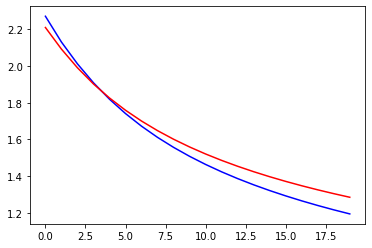

In [298]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(Scratch1dCNN.train_loss_list)), Scratch1dCNN.train_loss_list, color = "blue")
plt.plot(range(len(Scratch1dCNN.test_loss_list)), Scratch1dCNN.test_loss_list, color = "red")

まだロスが下がりそうだが、膨大な時間がかかる為、省略。

## 次元の呪いは、あぁ～～恐ろしや😱